<a href="https://colab.research.google.com/github/Gaurav55ks/Encryptix/blob/main/spam_detection_eda_97_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn import metrics
warnings.filterwarnings("ignore")

In [2]:
from google.colab import files
files.upload()

!kaggle datasets download -d uciml/sms-spam-collection-dataset
with zipfile.ZipFile("sms-spam-collection-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall(".")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 64.6MB/s]


In [3]:
spam_df = pd.read_csv("/content/spam.csv",encoding = 'Latin1')

In [4]:
spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
spam_df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [7]:
spam_df.drop(columns = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"],inplace = True)
spam_df.rename(columns = {"v1":"Target","v2":"Text"},inplace = True)
spam_df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


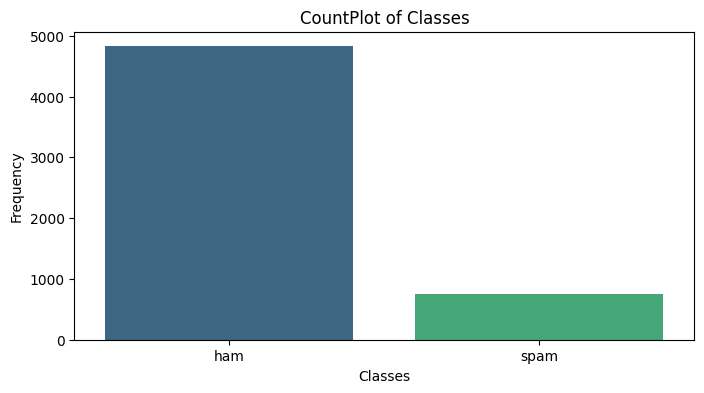

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(data=spam_df,x="Target",palette="viridis")
plt.title("CountPlot of Classes")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()

In [9]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
spam_df["Number_of_characters"] = spam_df["Text"].apply(len)
spam_df["Number_of_Words"] = spam_df.apply(lambda row : nltk.word_tokenize(row["Text"]),axis = 1).apply(len)
spam_df["Number_of_Sentences"] = spam_df.apply(lambda row : nltk.sent_tokenize(row["Text"]),axis=1).apply(len)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
spam_df[["Number_of_Words","Number_of_Sentences","Number_of_Words"]].head()

,Number_of_Words,Number_of_Sentences,Number_of_Words
0,24,2,24
1,8,2,8
2,37,2,37
3,13,1,13
4,15,1,15


In [11]:
spam_df.describe()

,Number_of_characters,Number_of_Words,Number_of_Sentences
count,5572.000000,5572.000000,5572.000000
mean,80.118808,18.699390,1.996411
std,59.690841,13.741932,1.520159
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.500000
75%,121.000000,27.000000,2.000000
max,910.000000,220.000000,38.000000


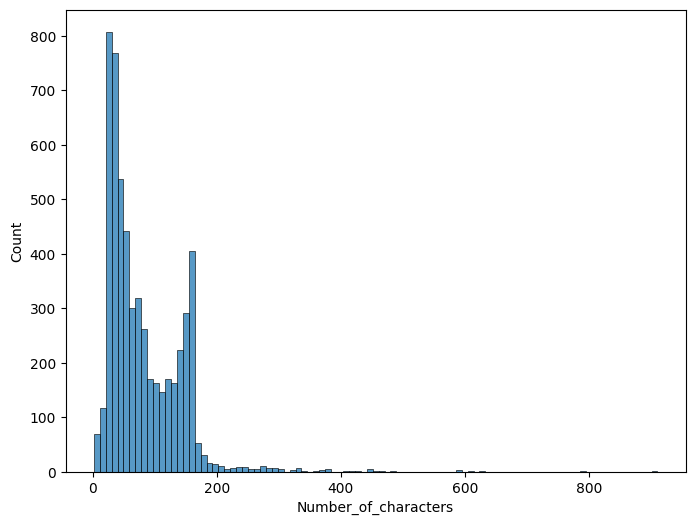

In [12]:
plt.figure(figsize=(8,6))
sns.histplot(data = spam_df,x="Number_of_characters")
plt.show()

In [13]:
print(f"Shape before removing outliers : {spam_df.shape}")
spam_df = spam_df[spam_df["Number_of_characters"]<350]
print(f"Shape after removing outliers : {spam_df.shape}")

Shape before removing outliers : (5572, 5)
Shape after removing outliers : (5548, 5)


<Figure size 800x600 with 0 Axes>

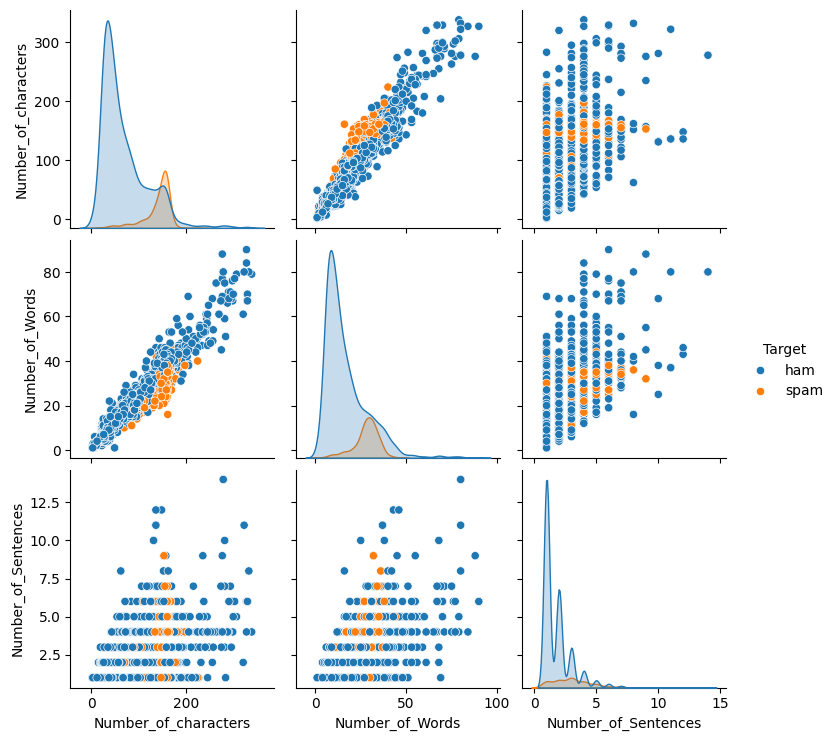

In [14]:
plt.figure(figsize=(8,6))
sns.pairplot(data = spam_df,hue="Target")
plt.show()

In [15]:
def cleaning(Text):
    Text = re.sub('[^a-zA-Z]', ' ',Text)
    Text = Text.lower()
    Text = Text.split()
    Text = " ".join(Text)
    return Text

def removing_stopwords(text):
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in text if word not in stop_words]
    return filtered_words

lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word,pos='v') for word in text]
    return lemmas

In [16]:
spam_df["Cleaned_Text"] = spam_df["Text"].apply(cleaning)
spam_df['Tokenize_Text'] = [nltk.word_tokenize(text) for text in spam_df["Cleaned_Text"]]
spam_df["NoStopWord_Text"] = spam_df["Tokenize_Text"].apply(removing_stopwords)
spam_df["Lemmatized_Text"] = spam_df["NoStopWord_Text"].apply(lemmatize_word)

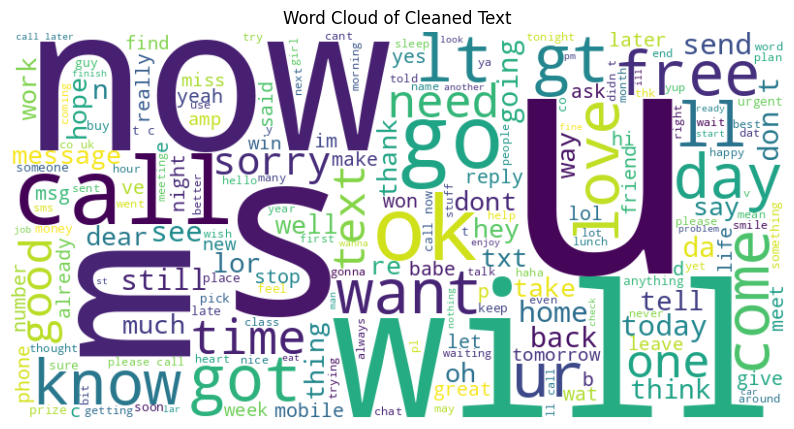

In [17]:
from wordcloud import WordCloud

all_cleaned_text = ' '.join(spam_df['Cleaned_Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_cleaned_text)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Cleaned Text')
plt.axis('off')
plt.show()

In [19]:
spam_df.columns

Index(['Target', 'Text', 'Number_of_characters', 'Number_of_Words',
       'Number_of_Sentences', 'Cleaned_Text', 'Tokenize_Text',
       'NoStopWord_Text', 'Lemmatized_Text'],
      dtype='object')

In [21]:
spam_df[['Cleaned_Text', 'Tokenize_Text',
       'NoStopWord_Text', 'Lemmatized_Text']]

,Cleaned_Text,Tokenize_Text,NoStopWord_Text,Lemmatized_Text
0,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"
...,...,...,...,...
5567,this is the nd time we have tried contact u u ...,"[this, is, the, nd, time, we, have, tried, con...","[nd, time, tried, contact, u, u, pound, prize,...","[nd, time, try, contact, u, u, pound, prize, c..."
5568,will b going to esplanade fr home,"[will, b, going, to, esplanade, fr, home]","[b, going, esplanade, fr, home]","[b, go, esplanade, fr, home]"
5569,pity was in mood for that so any other suggest...,"[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]","[pity, mood, suggestions]"
5570,the guy did some bitching but i acted like i d...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, somethi..."


In [22]:
corpus = []
for i in spam_df["Lemmatized_Text"]:
  msg = ' '.join([row for row in i])
  corpus.append(msg)

corpus[:5]

['go jurong point crazy available bugis n great world la e buffet cine get amore wat',
 'ok lar joke wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf live around though']

In [23]:
tfidf = TfidfVectorizer()
label_encoder = LabelEncoder()
X = tfidf.fit_transform(corpus).toarray()
spam_df["Target"] = label_encoder.fit_transform(spam_df["Target"])

In [24]:
y=spam_df["Target"]
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [25]:
classifiers = [MultinomialNB(),
               DecisionTreeClassifier(),
               SVC(),
               KNeighborsClassifier(),
               RandomForestClassifier()]
for i in classifiers:
  i.fit(X_train,y_train)

pict_dict = {0:"NaiveBayes",
             1:"DecisionTree",
             2:"SupportVectorMachine",
             3:"KNeighbors",
             4:"RandomForest"}

In [26]:
for i,model in enumerate(classifiers):
  cv_score = cross_val_score(model,X_train,y_train,scoring = "accuracy",cv=10)
  print(f"{pict_dict[i]} : {cv_score.mean():.2f}")

NaiveBayes : 0.97
DecisionTree : 0.96
SupportVectorMachine : 0.97
KNeighbors : 0.91
RandomForest : 0.98


In [27]:
## Models Evaluation
Precision = []
Recall = []
F1_Score = []
Trainset_Accuracy = []
Testset_Accuracy = []

for i in classifiers:
  pred_train = i.predict(X_train)
  pred_test = i.predict(X_test)
  precision = metrics.precision_score(y_test,pred_test)
  recall = metrics.recall_score(y_test,pred_test)
  f1_s = metrics.f1_score(y_test,pred_test)
  train_accuracy = i.score(X_train,y_train)
  test_accuracy = i.score(X_test,y_test)

  Precision.append(precision)
  Recall.append(recall)
  F1_Score.append(f1_s)
  Trainset_Accuracy.append(train_accuracy)
  Testset_Accuracy.append(test_accuracy)

In [30]:
data = {"Precision" : Precision,
        "Recall" : Recall,
        "F1_Score" : F1_Score,
        "TrainSet_Accuracy" : Trainset_Accuracy,
        "TestSet_Accuracy" : Testset_Accuracy}

Results = pd.DataFrame(data,index=["NaiveBayes","DecisionTree","SupportVectorMachine","KNeighbors","RandomForest"])

Results

,Precision,Recall,F1_Score,TrainSet_Accuracy,TestSet_Accuracy
NaiveBayes,1.000000,0.705882,0.827586,0.976341,0.963964
DecisionTree,0.876923,0.838235,0.857143,1.000000,0.965766
SupportVectorMachine,0.990909,0.801471,0.886179,0.997521,0.974775
KNeighbors,0.977778,0.323529,0.486188,0.927219,0.916216
RandomForest,1.000000,0.816176,0.898785,1.000000,0.977477
